# Ragionamento con Vincoli (CSP)
## Schedulazione degli Agenti nei Comuni
### Introduzione

La gestione efficiente delle risorse umane in situazioni critiche, come la prevenzione e il pronto intervento in aree ad alto rischio, rappresenta una sfida complessa che richiede un approccio metodologico rigoroso.

Questo problema può essere modellato come un Constraint Satisfaction Problem (CSP). I vincoli rigidi definiscono le condizioni necessarie per una soluzione ammissibile, mentre i vincoli flessibili permettono di esprimere preferenze o priorità, come la copertura dei comuni con il più alto numero di incidenti o la distribuzione degli agenti nelle fasce orarie più critiche.
L'obiettivo è generare assegnazioni che soddisfino i vincoli rigidi e ottimizzino quelli flessibili.

>### Richiami teorici:
>- Variabili: Un insieme di variabili 
$X = {X_1, X_2, \ldots, X_n}$.
>- Domini: Ogni variabile $X_i$ ha un dominio $D_i$, che è l'insieme dei valori che può assumere.
>- Vincoli: Un insieme di vincoli 
$C = {C_1, C_2, \ldots, C_m}$ 
>che specificano le relazioni legittime tra le variabili. Ogni vincolo può limitare i valori che le variabili possono assumere simultaneamente.

| Algoritmo               | Punti di Forza                                                                 | Punti di Debolezza                                                           | Complessità Computazionale                     | Casi d'Uso                      |
|-------------------------|-------------------------------------------------------------------------------|------------------------------------------------------------------------------|------------------------------------------------|----------------------------------|
| Generate & Test         | - Semplice da implementare <br> - Facile da comprendere                       | - Inefficiente per spazi di ricerca grandi <br> - Non garantisce soluzione ottimale | O(d^n) (d = numero di possibili assegnazioni, n = numero di variabili) | Problemi di piccola scala       |
| Simulated Annealing     | - Buona esplorazione dello spazio di ricerca <br> - Può trovare soluzioni vicine all'ottimo | - Parametri sensibili (temperatura, rate di raffreddamento) <br> - Non garantisce la convergenza | O(k), dove k è il numero di iterazioni (dipende dai parametri) | Ottimizzazione di problemi complessi |

## Tecnologie/Librerie utilizzate:
- Python
- Pandas (Gestione del Dataset)
- Matplotlib (Creazione dei grafici)
- Random 
- Time
- Math

## Algoritmi implementati:
- **Generate & Test** (Base e Incrementale)
- **Simulated Annealing** (Ricerca locale stocastica)

## Pulizia del Dataset e estrazione delle informazioni utili al Problema
Prima testare algoritmi che risolvono questo CSP, è necessario pulire e preparare il dataset per estrarre le informazioni rilevanti al problema che vogliamo risolvere.

### Struttura del Codice
Il codice esegue le seguenti operazioni principali:

1. Caricamento del dataset contenente i dati sugli incidenti stradali.
2. Selezione delle feature rilevanti.
3. Pulizia dei dati e gestione dei valori mancanti.
4. Creazione delle fasce orarie.
5. Assegnazione di pesi per la tipologia di strada e intersezione.
6. Aggregazione dei dati per comune e fascia oraria.
7. Calcolo dell'indice di pericolosità.
8. Normalizzazione dell'indice di pericolosità.
9.  Salvataggio del dataset processato.

### Codice:

In [11]:
import pandas as pd
import os

# Percorso del dataset
data_set_path = os.getcwd()
save_path = os.path.join(data_set_path, 'Dati', "CSP.csv")
data_set_path = os.path.join(data_set_path, 'Dati', 'DataSet_Incidenti_Puglia.csv')

# Features utili
useful_features = ["ANNO", "MESE", "GIORNO", "ORA_APP", "PROV", "COMUNE", "REG", "LOCINC", "INTNIN", "XCOORD_ACI", "YCOORD_ACI", "MORTI", "FERITI"] 

# Lettura del dataset
df = pd.read_csv(data_set_path, dtype={
    "ANNO": "int32", "MESE" : "int32", "GIORNO" : "int32", "ORA_APP" : "int32", "LOCINC" : "int32", 
    "INTNIN" : "int32", "XCOORD_ACI" : "float64", "YCOORD_ACI" : "float64", "MORTI" : "int32", "FERITI" : "int32",
    "PROV" : "str", "COMUNE" : "str", "REG" : "str"
}, low_memory=False)

# Creiamo una copia separata del dataframe
filtered_df = df[useful_features].copy()

filtered_df = filtered_df.dropna()

# Correzione ORA_APP (da 1-25 a 0-23)
filtered_df["ORA_APP"] = filtered_df["ORA_APP"].apply(lambda x: x - 1 if x <= 24 else 0)

# Creazione delle fasce orarie
fasce_orarie = [(0, 6, "Notte"), (6, 12, "Mattina"), (12, 18, "Pomeriggio"), (18, 24, "Sera")]

def get_fascia_oraria(ora):
    for start, end, nome in fasce_orarie:
        if start <= ora < end:
            return nome
    return "Sconosciuto"

filtered_df.loc[:, "FASCIA_ORARIA"] = filtered_df["ORA_APP"].apply(get_fascia_oraria)

# Dizionario dei pesi per la localizzazione della strada
pesi_strada = {
    1: 1.2, 2: 1.3, 3: 1.5, 0: 1.4, # Nell'abitato
    4: 1.6, 5: 1.7, 6: 1.8, 7: 2.0, 8: 1.1, 9: 1.9  # Fuori abitato
}

# Dizionario dei pesi per la tipologia di strada (Intersezione non intersezione)
pesi_tipologia_strada = {
    1: 2, 2: 1.5, 3: 0.2, 4: 0.2, 5: 1, 6: 0.5,
    7: 0.2, 8: 0.4, 9: 0.4, 10: 0.2, 11: 0.2, 12: 1.2 
}

# Raggruppamento per comune e fascia oraria
incidenti_aggregati = filtered_df.groupby(["COMUNE", "FASCIA_ORARIA"]).agg(
    incidenti_totali=("ORA_APP", "count"),
    morti_totali=("MORTI", "sum"),
    feriti_totali=("FERITI", "sum"),
    intnin_totali=("INTNIN", lambda x: x.map(pesi_tipologia_strada).sum()),
    locinc_totali=("LOCINC", lambda x: x.map(pesi_strada).sum())
).reset_index()

# Calcolo del peso combinato per rischio incidenti
incidenti_aggregati["PESO_RISCHIO"] = (
    0.3 * incidenti_aggregati["intnin_totali"] +
    0.5 * incidenti_aggregati["morti_totali"] +
    0.2 * incidenti_aggregati["feriti_totali"] +
    0.4 * incidenti_aggregati["locinc_totali"]
)

# Normalizzazione dei pesi
peso_min = incidenti_aggregati["PESO_RISCHIO"].min()
peso_max = incidenti_aggregati["PESO_RISCHIO"].max()
incidenti_aggregati["PESO_RISCHIO_NORM"] = (incidenti_aggregati["PESO_RISCHIO"] - peso_min) / (peso_max - peso_min)

# Salvataggio del risultato
incidenti_aggregati.to_csv(save_path, index=False)
print("Incidenti aggregati per comune e fascia oraria:")
print(incidenti_aggregati.head(15))

Incidenti aggregati per comune e fascia oraria:
   COMUNE FASCIA_ORARIA  incidenti_totali  morti_totali  feriti_totali  \
0       1       Mattina               961            14           1447   
1       1         Notte                99             2            147   
2       1    Pomeriggio              1132            15           1803   
3       1          Sera               792            10           1309   
4      10       Mattina               270             4            404   
5      10         Notte                33             7             52   
6      10    Pomeriggio               353            11            588   
7      10          Sera               181             4            353   
8      11       Mattina               297             6            485   
9      11         Notte                39             7             71   
10     11    Pomeriggio               361             5            637   
11     11          Sera               217             3         

#### Funzione utilizzata per calcolare l'indice di pericolosità:
$$ PESO\_RISCHIO = 0.3 \times INTNIN + 0.5 \times MORTI + 0.2 \times FERITI + 0.4 \times LOCINC $$

Dove:<br>

- $INTNIN$ è il numero totale di intersezioni ponderate,
- $MORTI$ è il numero totale di morti,
- $FERITI$ è il numero totale di feriti,
- $LOCINC$ è il numero totale di incidenti in base alla tipologia di strada.

> ***Nota***: I campi  e  sono stati scelti arbitrariamente per rendere la funzione di calcolo del rischio più complessa. Si potrebbero considerare anche altri campi del dataset per definire una funzione di rischio più specifica e affine alle esigenze del problema. Inoltre, il campo COMUNE è rappresentato dal codice ISTAT corrispondente, che identifica univocamente ogni comune italiano.

Successivamente l'indice viene normalizzato tra 0 e 1 utilizzando la formula:
$$ PESO\_RISCHIO\_NORM = \frac{PESO\_RISCHIO - min(PESO\_RISCHIO)}{max(PESO\_RISCHIO) - min(PESO\_RISCHIO)} $$

## 1° APPROCCIO | Generate&Test
#### Variabili:
- **AGENTE**: gli agenti disponibili per la schedulazione.
- **COMUNE**: il comune in cui devono operare gli agenti.
- **TURNO**: la fascia oraria assegnata all'agente.
- **ORE**: le ore lavorate da un agente in un determinato turno.
  
#### Domini:
- **AGENTE**: insieme degli agenti disponibili.
- **COMUNE**: insieme dei comuni da coprire.
- **TURNO**: {Mattina, Pomeriggio, Sera, Notte}.
- **ORE**: numero massimo di ore lavorabili per turno.

#### Vincoli Rigidi:
- **Ore massime per agente**: ogni agente può lavorare al massimo un numero prefissato di ore.
- Un agente non può essere assegnato a più comuni nello stesso turno.
- **Numero minimo di agenti per comune**: ogni comune deve avere almeno un numero minimo di agenti assegnati.
- **Assegnazione unica per comune per turno**: ogni comune può essere coperto da un agente in uno specifico turno.

#### Algoritmo implementato
Generazione casuale di una soluzione iniziale, assegnando agenti a comuni in turni casuali. Successivamenteogni soluzione viene valutata per verificare se soddisfa i vincoli rigidi, se la soluzione non è valida, viene generata una nuova soluzione casuale. L'algoritmo termina quando viene trovata un'assegnazione che soddisfa i vincoli.

### Codice:

In [ ]:
import pandas as pd
import os
import random
import time
import matplotlib.pyplot as plt

def serialize_solution(soluzione):
    """
    Serializza una soluzione (lista di dizionari) in una tupla immutabile.
    """
    # Ordina la soluzione per chiave principale (es. COMUNE, AGENTE, TURNO)
    sorted_solution = sorted(
        soluzione,
        key=lambda x: (x["COMUNE"], x["AGENTE"], x["TURNO"])
    )
    # Converte ogni dizionario in una tupla di coppie chiave-valore
    serialized = tuple(
        tuple(sorted(assegnazione.items())) for assegnazione in sorted_solution
    )
    return serialized

class DataLoader:
    def __init__(self, file_path):
        self.file_path = file_path
        self.df = None

    def load_and_preprocess(self, num_agenti, num_min_agenti_zona):
        """Carica e prepara i dati calcolando gli agenti richiesti"""
        self.df = pd.read_csv(self.file_path)
        
        # Calcola agenti richiesti proporzionalmente al rischio
        self.df["AGENTI_RICHIESTI"] = ((self.df["PESO_RISCHIO_NORM"] / self.df["PESO_RISCHIO_NORM"].sum()) * num_agenti).astype(int)
        self.df["AGENTI_RICHIESTI"] = self.df["AGENTI_RICHIESTI"].clip(lower=num_min_agenti_zona)
        
        # Ordina per pericolosità
        self.df = self.df.sort_values(by="PESO_RISCHIO_NORM", ascending=False)
        return self.df


class AgentScheduler:
    def __init__(self, incidenti_df, num_agenti, ore_max_agente, fasce_orarie, ore_per_turno):
        self.incidenti_df = incidenti_df
        self.fasce_orarie = fasce_orarie
        self.ore_per_turno = ore_per_turno
        self.ore_max_agente = ore_max_agente
        
        # Inizializza agenti
        self.agenti = [f"Agente_{i+1}" for i in range(num_agenti)]
        self.invalid_solutions = set()  # Lista per soluzioni non valide | Nel caso si volesse utilizzare, ma consuma molta memoria

    def generate_random_solution(self):
        """Genera una soluzione completamente casuale"""
        assegnazione = []
        for _, row in self.incidenti_df.iterrows():
            num_agenti_richiesti = row["AGENTI_RICHIESTI"]
            turno = random.choice(self.fasce_orarie)
            agenti_assegnati = random.sample(self.agenti, num_agenti_richiesti)
            assegnazione.extend([{
                "COMUNE": row["COMUNE"],
                "AGENTE": agente,
                "TURNO": turno,
                "ORE": self.ore_per_turno
            } for agente in agenti_assegnati])
        return assegnazione

    def is_valid_solution(self, soluzione):
        """Verifica se una soluzione soddisfa i vincoli"""
        ore_lavorate = {agente: 0 for agente in self.agenti}
        comuni_assegnati = {fascia: set() for fascia in self.fasce_orarie}
        
        for assegnazione in soluzione:
            agente = assegnazione["AGENTE"]
            turno = assegnazione["TURNO"]
            comune = assegnazione["COMUNE"]
            
            # Vincolo sulle ore massime per agente
            if ore_lavorate[agente] + self.ore_per_turno > self.ore_max_agente:
                return False
            
            # Vincolo sui comuni già assegnati nel turno
            if comune in comuni_assegnati[turno]:
                return False
            
            # Aggiorna stato
            ore_lavorate[agente] += self.ore_per_turno
            comuni_assegnati[turno].add(comune)
        
        return True

    def generate_and_test(self):
        """Genera soluzioni fino a trovare una valida"""
        count = 1
        while True:
            #print(f"Tentativo {count} ", end="")
            soluzione = self.generate_random_solution()
            serialized_solution = hash(serialize_solution(soluzione))
            if serialized_solution in self.invalid_solutions:
                #print("Fallito (Soluzione già testata)")
                self.invalid_solutions.add(serialized_solution)
                count += 1
                continue
            if self.is_valid_solution(soluzione):
                #print("Riuscito!")
                return soluzione
            count += 1
            #print("Fallito!")


class Visualizer:
    def __init__(self, scheduling_data, incidenti_df):
        self.scheduling_df = pd.DataFrame(scheduling_data)
        self.incidenti_df = incidenti_df

    def prepare_data(self):
        """Prepara i dati per la visualizzazione"""
        self.scheduling_df["DURATA"] = self.scheduling_df["AGENTE"].apply(lambda x: 2 if "*" in x else 6)
        self.scheduling_df = self.scheduling_df.merge(
            self.incidenti_df[["COMUNE", "PESO_RISCHIO_NORM"]], 
            on="COMUNE", 
            how="left"
        )
        # Aggrega i dati per comune
        self.turni_aggregati = self.scheduling_df.groupby(["COMUNE", "DURATA"]).size().unstack(fill_value=0)
        self.turni_aggregati["PESO_RISCHIO_NORM"] = self.scheduling_df.groupby("COMUNE")["PESO_RISCHIO_NORM"].mean()

    def plot_distribution(self):
        """Mostra il grafico della distribuzione"""
        self.prepare_data()
        fig, ax = plt.subplots(figsize=(12, 6))
        
        # Plot stacked bars
        self.turni_aggregati[[2, 6]].plot(kind="bar", stacked=True, ax=ax, colormap="viridis")
        
        # Aggiungi scala colori rischio
        norm = plt.Normalize(self.turni_aggregati["PESO_RISCHIO_NORM"].min(), self.turni_aggregati["PESO_RISCHIO_NORM"].max())
        sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)
        sm.set_array([])
        plt.colorbar(sm, ax=ax, label="Fattore di Rischio Normalizzato")
        ax.set_title("Distribuzione Agenti per Comune e Durata Turno")
        ax.set_xlabel("Comune")
        ax.set_ylabel("Numero Agenti")
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()


class CSPOptimizer:
    def __init__(self, params):
        self.params = params
        self.data_loader = DataLoader(params['file_path'])
        self.scheduler = None
        self.visualizer = None

    def run(self):
        """Esegue l'intero processo di ottimizzazione"""
        # Caricamento dati
        incidenti_df = self.data_loader.load_and_preprocess(
            self.params['NUM_AGENTI'], 
            self.params['NUM_MIN_AGENTI_ZONA']
        )
        # Inizializzazione scheduler
        self.scheduler = AgentScheduler(
            incidenti_df=incidenti_df,
            num_agenti=self.params['NUM_AGENTI'],
            ore_max_agente=self.params['ORE_MAX_AGENTE'],
            fasce_orarie=self.params['FASCE_ORARIE'],
            ore_per_turno=self.params['ORE_PER_TURNO']
        )
        start_time = time.time()
        soluzione = self.scheduler.generate_and_test()
        end_time = time.time()
        # Visualizzazione risultati
        self.visualizer = Visualizer(soluzione, incidenti_df)
        self.visualizer.plot_distribution()
        # Stampa risultati
        print("\nPrime 10 assegnazioni:")
        for item in soluzione[:10]:
            print(item)
        print(f"\nTempo esecuzione: {end_time - start_time:.4f} secondi")


# Configurazione parametri
params = {
    'file_path': os.path.join(os.getcwd(), 'Dati', "CSP.csv"),
    'NUM_AGENTI': 1000, 
    'ORE_MAX_AGENTE': 8,
    'NUM_MIN_AGENTI_ZONA': 2,
    'FASCE_ORARIE': ["Mattina", "Pomeriggio", "Sera", "Notte"],
    'ORE_PER_TURNO': 6
}

# Esecuzione principale
if __name__ == "__main__":
    optimizer = CSPOptimizer(params)
    optimizer.run()

### Complessità del Problema e Limiti dell'Approccio Generate & Test
Come c'era da aspettarsi però, questo tipo di approccio non è molto efficace per risolvere questo tipo di problema. La complessità infatti cresce esponenzialmente con il numero di agenti, comuni e turni.
Nel caso peggiore è:

$O(d^n)$

dove:<br>

- $d$ è il numero di possibili assegnazioni per ogni variabile (es. turni disponibili per un agente),
- $n$ è il numero totale di variabili (es. agenti da assegnare).

Per problemi con molteplici agenti e comuni, il numero di combinazioni esplorabili diventa proibitivo, rendendo questo metodo inefficiente. In scenari reali con centinaia di agenti e turni, il numero di soluzioni possibili può facilmente superare i miliardi, causando lunghi tempi di computazione e alto consumo di risorse.
Infatti lanciando lo script con solo centinaia di agenti l'algoritmo non ha trovato soluzione in un tempo ragionevole. Anche implementando un set per le assegnazioni generate non valide. Per questo motivo è necessario un approccio diverso.

## 2° APPROCCIO | Generate&Test | Incrementale 
Vincoli e variabili sono le stesse del 1° approccio, con la differenza che qui un agente oltre a fare un turno da 6 ore, può fare anche un turno in un altro comune e in un'altra fascia oraria di 2 ore, visto che il turno lavorativo complessivo di un agente è di 8 ore (al giorno).
La seguente implementazione costruisce la soluzione/assegnazione parzialmente, aggiungendo un agente alla volta.
Si verifica la validità della soluzione parziale prima di procedere. Se un vincolo viene violato, si abbandona quel ramo della ricerca.

In questa maniera si riduce lo spazio di ricerca eliminando assegnazioni parziali non valide, rendendo l'implementazione più efficiente rispetto al Generate&Test classico.

Il numero di agenti richiesti per comune viene calcolato in questa maniera:
$$
\text{AGENTI\_RICHIESTI} = \left( \frac{\text{PESO\_RISCHIO\_NORM}}{\sum_{i=1}^{n} \text{PESO\_RISCHIO\_NORM}_i} \times \text{NUM\_TOTALE\_AGENTI} \right)
$$

### Codice:

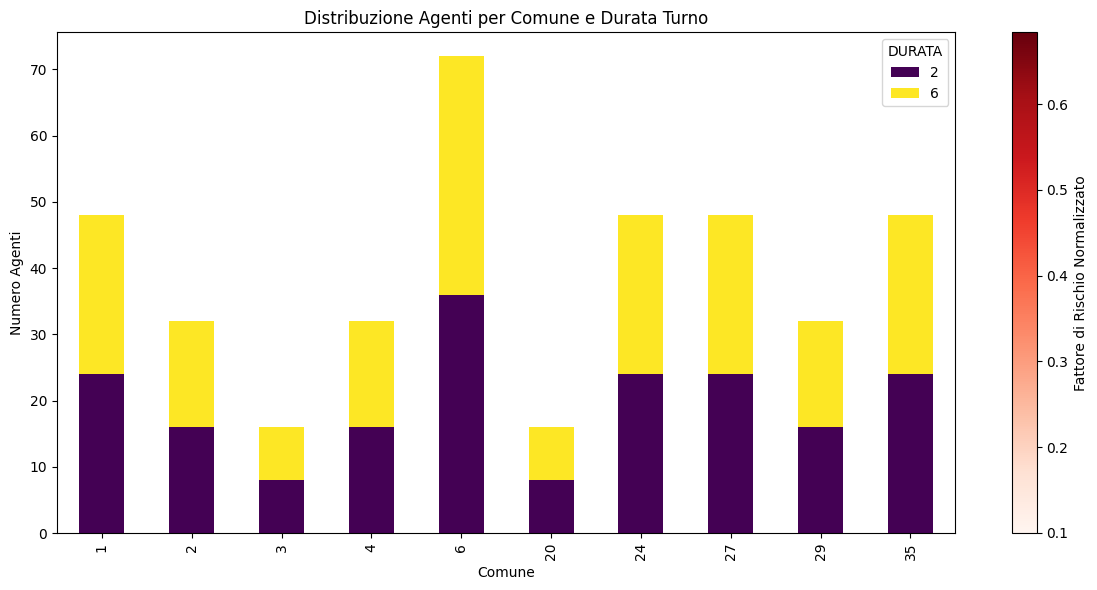


Prime 10 assegnazioni:
{'COMUNE': 6, 'AGENTE': 'Agente_1*', 'TURNO': 'Pomeriggio', 'ORE': 2}
{'COMUNE': 6, 'AGENTE': 'Agente_2*', 'TURNO': 'Mattina', 'ORE': 2}
{'COMUNE': 6, 'AGENTE': 'Agente_3*', 'TURNO': 'Notte', 'ORE': 2}
{'COMUNE': 6, 'AGENTE': 'Agente_1', 'TURNO': 'Sera', 'ORE': 6}
{'COMUNE': 6, 'AGENTE': 'Agente_2', 'TURNO': 'Sera', 'ORE': 6}
{'COMUNE': 6, 'AGENTE': 'Agente_3', 'TURNO': 'Sera', 'ORE': 6}
{'COMUNE': 6, 'AGENTE': 'Agente_4*', 'TURNO': 'Mattina', 'ORE': 2}
{'COMUNE': 6, 'AGENTE': 'Agente_5*', 'TURNO': 'Pomeriggio', 'ORE': 2}
{'COMUNE': 6, 'AGENTE': 'Agente_4', 'TURNO': 'Notte', 'ORE': 6}
{'COMUNE': 6, 'AGENTE': 'Agente_5', 'TURNO': 'Notte', 'ORE': 6}

Tempo esecuzione: 0.0201 secondi


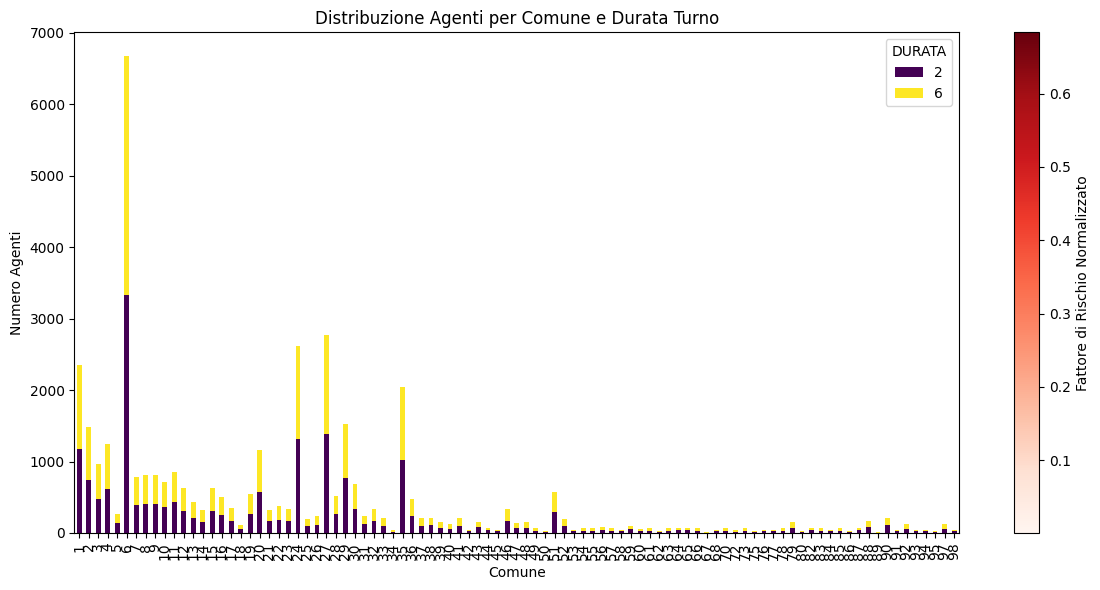


Prime 10 assegnazioni:
{'COMUNE': 6, 'AGENTE': 'Agente_1*', 'TURNO': 'Mattina', 'ORE': 2}
{'COMUNE': 6, 'AGENTE': 'Agente_2*', 'TURNO': 'Pomeriggio', 'ORE': 2}
{'COMUNE': 6, 'AGENTE': 'Agente_3*', 'TURNO': 'Notte', 'ORE': 2}
{'COMUNE': 6, 'AGENTE': 'Agente_4*', 'TURNO': 'Mattina', 'ORE': 2}
{'COMUNE': 6, 'AGENTE': 'Agente_5*', 'TURNO': 'Pomeriggio', 'ORE': 2}
{'COMUNE': 6, 'AGENTE': 'Agente_6*', 'TURNO': 'Mattina', 'ORE': 2}
{'COMUNE': 6, 'AGENTE': 'Agente_7*', 'TURNO': 'Pomeriggio', 'ORE': 2}
{'COMUNE': 6, 'AGENTE': 'Agente_8*', 'TURNO': 'Pomeriggio', 'ORE': 2}
{'COMUNE': 6, 'AGENTE': 'Agente_9*', 'TURNO': 'Pomeriggio', 'ORE': 2}
{'COMUNE': 6, 'AGENTE': 'Agente_10*', 'TURNO': 'Pomeriggio', 'ORE': 2}

Tempo esecuzione: 0.3087 secondi


In [ ]:
import pandas as pd
import os
import random
import time
import matplotlib.pyplot as plt

class DataLoader:
    def __init__(self, file_path):
        self.file_path = file_path
        self.df = None

    def load_and_preprocess(self, num_agenti, num_min_agenti_zona):
        """Carica e prepara i dati calcolando gli agenti richiesti"""
        self.df = pd.read_csv(self.file_path)
        
        # Calcola agenti richiesti per zona proporzionalmente al rischio
        self.df["AGENTI_RICHIESTI"] = ((self.df["PESO_RISCHIO_NORM"] / self.df["PESO_RISCHIO_NORM"].sum()) * num_agenti).astype(int)
        self.df["AGENTI_RICHIESTI"] = self.df["AGENTI_RICHIESTI"].clip(lower=num_min_agenti_zona)
        
        # Ordina per pericolosità
        self.df = self.df.sort_values(by="PESO_RISCHIO_NORM", ascending=False)
        return self.df


class AgentScheduler:
    def __init__(self, incidenti_df, num_agenti, ore_max_agente, fasce_orarie, ore_per_turno, ore_extra):
        self.incidenti_df = incidenti_df
        self.fasce_orarie = fasce_orarie
        self.ore_per_turno = ore_per_turno
        self.ore_extra = ore_extra
        self.ore_max_agente = ore_max_agente
        
        # Inizializza agenti e ore lavorate
        self.agenti = [f"Agente_{i+1}" for i in range(num_agenti)]
        self.ore_lavorate = {agente: 0 for agente in self.agenti}

    def generate_assignment(self):
        """Genera un'assegnazione valida rispettando i vincoli"""
        assegnazione = []
        comuni_assegnati = {fascia: set() for fascia in self.fasce_orarie}
        
        for _, row in self.incidenti_df.iterrows():
            num_agenti_richiesti = row["AGENTI_RICHIESTI"]
            
            # Ordina gli agenti per ore lavorate (meno ore -> più probabilità di essere scelti)
            agenti_disponibili = sorted(
                [a for a in self.agenti if self.ore_lavorate[a] + self.ore_per_turno <= self.ore_max_agente],
                key=lambda a: self.ore_lavorate[a]
            ) # Forma di propagazione dei vincoli , limitando la scelta degli agenti disponibili in base al numero di ore già lavorate.
            
            if len(agenti_disponibili) < num_agenti_richiesti:
                continue  # Salta se non ci sono abbastanza agenti
            
            # Seleziona un turno non utilizzato per il comune
            turno = random.choice(self.fasce_orarie)
            while row["COMUNE"] in comuni_assegnati[turno]:
                turno = random.choice(self.fasce_orarie)
            comuni_assegnati[turno].add(row["COMUNE"])
            
            # Assegna agenti e gestisci ore lavorate
            agenti_assegnati = agenti_disponibili[:num_agenti_richiesti] # Gli agenti vengono assegnati in modo incrementale, rispettando i vincoli sul numero massimo di ore lavorative.
            
            for agente in agenti_assegnati:
                self.ore_lavorate[agente] += self.ore_per_turno
                
                # Assegnazione ore extra per completare orario
                if self.ore_lavorate[agente] == self.ore_per_turno: # Gestione delle Ore Extra
                    turno_extra = random.choice([t for t in self.fasce_orarie if t != turno])
                    self.ore_lavorate[agente] += self.ore_extra
                    assegnazione.append({
                        "COMUNE": row["COMUNE"],
                        "AGENTE": f"{agente}*",
                        "TURNO": turno_extra,
                        "ORE": self.ore_extra
                    })
            
            # Aggiungi i turni principali
            assegnazione.extend([{
                "COMUNE": row["COMUNE"],
                "AGENTE": agente,
                "TURNO": turno,
                "ORE": self.ore_per_turno
            } for agente in agenti_assegnati])
        
        return assegnazione


class Visualizer:
    def __init__(self, scheduling_data, incidenti_df):
        self.scheduling_df = pd.DataFrame(scheduling_data)
        self.incidenti_df = incidenti_df

    def prepare_data(self):
        """Prepara i dati per la visualizzazione"""
        self.scheduling_df["DURATA"] = self.scheduling_df["AGENTE"].apply(lambda x: 2 if "*" in x else 6)
        self.scheduling_df = self.scheduling_df.merge(
            self.incidenti_df[["COMUNE", "PESO_RISCHIO_NORM"]], 
            on="COMUNE", 
            how="left"
        )
        # Aggrega i dati per comune
        self.turni_aggregati = self.scheduling_df.groupby(["COMUNE", "DURATA"]).size().unstack(fill_value=0)
        self.turni_aggregati["PESO_RISCHIO_NORM"] = self.scheduling_df.groupby("COMUNE")["PESO_RISCHIO_NORM"].mean()

    def plot_distribution(self):
        """Mostra il grafico della distribuzione"""
        self.prepare_data()
        fig, ax = plt.subplots(figsize=(12, 6))
        
        # Plot stacked bars
        self.turni_aggregati[[2, 6]].plot(kind="bar", stacked=True, ax=ax, colormap="viridis")
        
        # Aggiungi scala colori rischio
        norm = plt.Normalize(self.turni_aggregati["PESO_RISCHIO_NORM"].min(), self.turni_aggregati["PESO_RISCHIO_NORM"].max())
        sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)
        sm.set_array([])
        plt.colorbar(sm, ax=ax, label="Fattore di Rischio Normalizzato")
        ax.set_title("Distribuzione Agenti per Comune e Durata Turno")
        ax.set_xlabel("Comune")
        ax.set_ylabel("Numero Agenti")
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()


class CSPOptimizer:
    def __init__(self, params):
        self.params = params
        self.data_loader = DataLoader(params['file_path'])
        self.scheduler = None
        self.visualizer = None

    def run(self):
        """Esegue l'intero processo di ottimizzazione"""
        # Caricamento dati
        incidenti_df = self.data_loader.load_and_preprocess(
            self.params['NUM_AGENTI'], 
            self.params['NUM_MIN_AGENTI_ZONA']
        )
        # Inizializzazione scheduler
        self.scheduler = AgentScheduler(
            incidenti_df=incidenti_df,
            num_agenti=self.params['NUM_AGENTI'],
            ore_max_agente=self.params['ORE_MAX_AGENTE'],
            fasce_orarie=self.params['FASCE_ORARIE'],
            ore_per_turno=self.params['ORE_PER_TURNO'],
            ore_extra=self.params['ORE_EXTRA']
        )
        # Generazione soluzione
        start_time = time.time()
        soluzione = self.scheduler.generate_assignment()
        end_time = time.time()
        # Visualizzazione risultati
        self.visualizer = Visualizer(soluzione, incidenti_df)
        self.visualizer.plot_distribution()
        # Stampa risultati
        print("\nPrime 10 assegnazioni:")
        for item in soluzione[:10]:
            print(item)
        print(f"\nTempo esecuzione: {end_time - start_time:.4f} secondi")


# Configurazione parametri 1 
params = {
    'file_path': os.path.join(os.getcwd(), 'Dati', "CSP.csv"),
    'NUM_AGENTI': 50,
    'ORE_MAX_AGENTE': 8,
    'NUM_MIN_AGENTI_ZONA': 2,
    'FASCE_ORARIE': ["Mattina", "Pomeriggio", "Sera", "Notte"],
    'ORE_PER_TURNO': 6,
    'ORE_EXTRA': 2
}

# Configurazione parametri 2
params2 = {
    'file_path': os.path.join(os.getcwd(), 'Dati', "CSP.csv"),
    'NUM_AGENTI': 5000,
    'ORE_MAX_AGENTE': 8,
    'NUM_MIN_AGENTI_ZONA': 2,
    'FASCE_ORARIE': ["Mattina", "Pomeriggio", "Sera", "Notte"],
    'ORE_PER_TURNO': 6,
    'ORE_EXTRA': 2
}

# Esecuzione principale
if __name__ == "__main__":
    optimizer = CSPOptimizer(params) # Primo Run
    optimizer.run()
    optimizer = CSPOptimizer(params2) # Secondo Run 
    optimizer.run()

Le soluzioni in questo caso vengono trovate e anche in un tempo molto breve. Possiamo osservare che:

**Primo grafico (NUM_AGENTI = 50)**:<br>

- La distribuzione degli agenti nei comuni è più uniforme, con picchi moderati.
- L'algoritmo assegna agenti solo ai comuni più a rischio, privilegiando le aree con maggiore pericolosità rispetto ad altre.

**Secondo grafico (NUM_AGENTI = 5000)**:<br>

- L'aumento drastico del numero di agenti porta a picchi elevati in alcuni comuni, mostrando una distribuzione meno uniforme.
- Alcuni comuni ricevono un numero di agenti sproporzionato rispetto ad altri, creando squilibri.
- Tuttavia però, viene trovata una soluzione ragionevole.

## 3° Approccio | SimulatedAnnealing

Le **variabili** rimangono:<br>

- **Agenti**: Rappresentati da ```self.agenti = [f"Agente_{i+1}" for i in range(num_agenti)]```.
- **Comuni**: Derivati dal DataFrame ```incidenti_df["COMUNE"]```.
- **Turni**: Forniti come ```fasce_orarie = ["Mattina", "Pomeriggio", "Sera", "Notte"]```.

**Vincoli**:<br>

- Ogni comune deve avere almeno ```AGENTI_RICHIESTI``` agenti (sempre calcolato in base al rischio del comune con la formula mostra precedentemente).
- Ore lavorative massime per agente: Nessun agente può superare ```ORE_MAX_AGENTE```.
- Bilanciamento dei turni: il numero di agenti assegnati a ciascun turno dovrebbe essere bilanciato.
- Utilizzo di tutti gli agenti: Preferibile utilizzare il maggior numero possibile di agenti.

L'algoritmo segue (e prende in prestito una metafora dal dominio della metallugia) i principi della ricerca locale stocastica, combinando miglioramenti iterativi con mosse casuali per evitare minimi locali.
Prima generazione la soluzione iniziale: assegnando casualmente agenti ai comuni e ai turni, rispettando i requisiti minimi.
Includendo una probabilità del 20% di assegnare turni extra agli agenti. Successivamente effettua raffinazioni successive all'assegnazione iniziale applicando mutazioni casuali (swap, add_remove, shift_change) per generare nuove soluzioni vicine. 
Questo algoritmo utilizza un criterio probabilistico per accettare soluzioni peggiori, consentendo di esplorare lo spazio delle soluzioni e sfuggire ai minimi locali. Data l'assegnazione corrente $A$ e una nuova assegnazione $A'$, si calcola la differenza di costo tra le due:

$$\Delta E = h(A') - h(A)$$

dove $h(A)$ è la funzione di valutazione (ad esempio, il numero di conflitti o il costo totale). L'accettazione della nuova assegnazione avviene come segue:

1. **Se $\Delta E \leq 0$** (miglioramento):
   $$A' \text{ viene accettata direttamente.}$$

2. **Se $\Delta E > 0$** (peggioramento):
   $$A' \text{ viene accettata con probabilità: } P(\text{accettare}) = e^{-\frac{\Delta E}{T}}$$
   dove $T$ è la temperatura corrente.

#### Comportamento alle Temperature
- **Temperature Alte ($T$ grande)**:
   $$e^{-\frac{\Delta E}{T}} \to 1 \quad \text{(probabilità alta di accettare passi peggiorativi)}.$$

- **Temperature Basse ($T$ piccola)**:
   $$e^{-\frac{\Delta E}{T}} \to 0 \quad \text{(probabilità bassa di accettare passi peggiorativi)}.$$

#### Osservazioni
- Alle alte temperature, l'algoritmo tende ad accettare anche soluzioni che peggiorano significativamente la funzione obiettivo.
- Alle basse temperature, l'algoritmo si comporta in modo simile a una ricerca locale deterministica, accettando quasi esclusivamente miglioramenti.

### ***Funzione di Valutazione delle Assegnazioni:*** 
viene calcolata in questa maniera:
$$cost=0.4⋅p_ 
requisiti
​
 +0.3⋅p_{ore}
​
 +0.2⋅p_bilanciamento
​
 +0.1⋅p_inutilizzati$$

La funzione di costo calcola il costo totale della soluzione corrente combinando diverse penalità normalizzate. Le penalità sono progettate per valutare quanto la soluzione violi i vincoli rigidi e flessibili. Di seguito sono descritte le componenti principali:

#### 1. **Penalità per Soddisfazione dei Requisiti dei Comuni**
Questa penalità misura quanto i requisiti minimi di agenti per ogni comune siano soddisfatti. È calcolata come segue:

$$
p_{\text{requisiti}} = \frac{1}{\text{len(comuni)}} \sum \left( \frac{\text{req} - \text{comuni\_turni[comune].get(turno, 0)}}{\text{max\_requisiti}} \right)^2
$$

Dove:<br>

- $\text{req}$ è il numero di agenti richiesti per un comune.
- $\text{comuni\_turni[comune][turno]}$ è il numero di agenti assegnati al comune in un determinato turno.
- $\text{max\_requisiti}$ è il massimo numero di agenti richiesti tra tutti i comuni.

La penalità è normalizzata rispetto al numero di comuni.

#### 2. **Penalità per Ore Lavorative Massime**
Questa penalità penalizza gli agenti che superano il limite massimo di ore lavorative consentite. È calcolata come segue:

$$
p_{\text{ore}} = \frac{1}{\text{num\_agenti}} \sum \left( \frac{\text{ore} - \text{ore\_max\_agente}}{\text{max\_ore}} \right)^3 \quad \text{se } \text{ore} > \text{ore\_max\_agente}
$$

Dove:<br>

- $\text{ore}$ è il numero totale di ore lavorate da un agente.
- $\text{ore\_max\_agente}$ è il limite massimo di ore consentite per agente.
- $\text{max\_ore}$ è il valore massimo di ore considerato per la normalizzazione.

La penalità è applicata solo se le ore lavorate superano il limite consentito ed è normalizzata rispetto al numero di agenti.

#### 3. **Penalità per Bilanciamento dei Turni**
Questa penalità valuta quanto i turni siano distribuiti in modo equilibrato tra le fasce orarie. È calcolata come segue:

$$
p_{\text{bilanciamento}} = \sum \left| \frac{\text{count} - \text{avg\_turni}}{\text{avg\_turni}} \right|
$$

Dove:<br>

- $\text{count}$ è il numero di agenti assegnati a un determinato turno.
- $\text{avg\_turni}$ è il numero medio di agenti per turno, calcolato come:
  $$
  \text{avg\_turni} = \frac{\sum \text{turni\_count.values()}}{\text{len(turni\_count)}}
  $$

#### 4. **Penalità per Agenti Inutilizzati**
Questa penalità penalizza il numero di agenti che non sono stati utilizzati nella soluzione. È calcolata come segue:

$$
p_{\text{inutilizzati}} = \frac{\text{num\_agenti} - \text{len(agenti\_ore)}}{\text{num\_agenti}}
$$

Dove:<br>

- $\text{num\_agenti}$ è il numero totale di agenti disponibili.
- $\text{len(agenti\_ore)}$ è il numero di agenti effettivamente utilizzati.

### Codice:

Avvio ottimizzazione con Simulated Annealing...
Iterazione 0: Costo 0.1924 | Temperatura 999.00
Iterazione 500: Costo 0.1922 | Temperatura 605.77
Iterazione 1000: Costo 0.1918 | Temperatura 367.33
Iterazione 1500: Costo 0.1913 | Temperatura 222.74
Iterazione 2000: Costo 0.1910 | Temperatura 135.06
Iterazione 2500: Costo 0.1909 | Temperatura 81.90
Arresto anticipato all'iterazione 2557 per mancanza di miglioramenti.
Ottimizzazione completata in 120.75 secondi


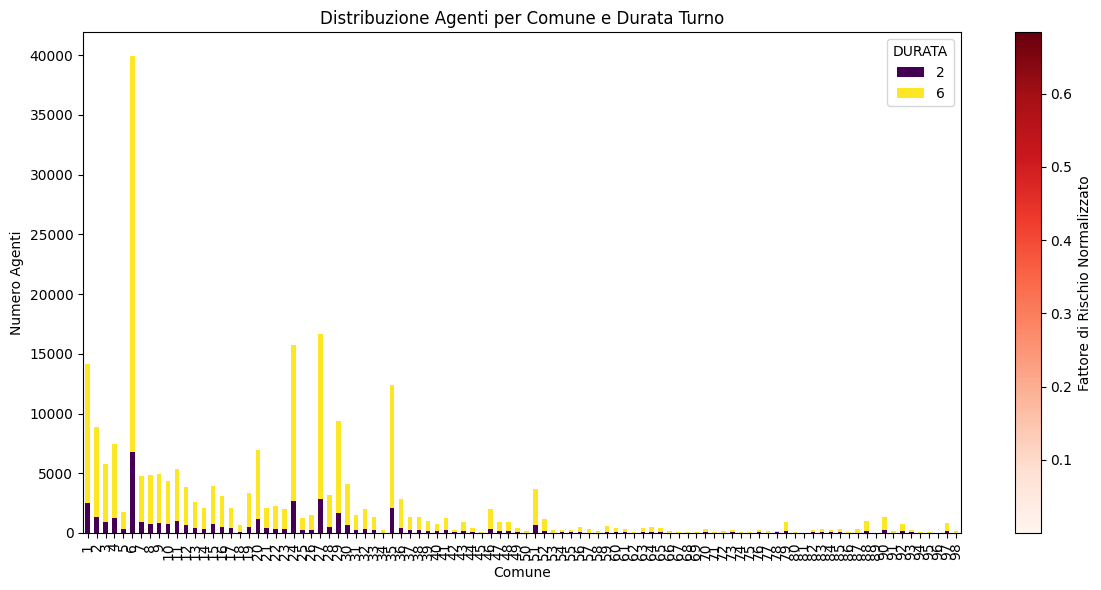

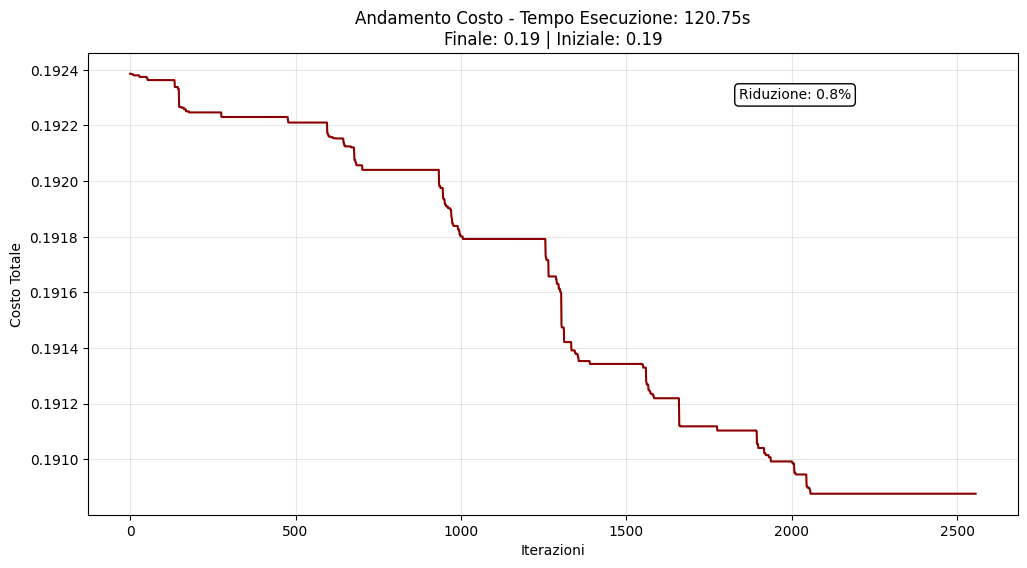

In [ ]:
import pandas as pd
import os
import random
import time
import matplotlib.pyplot as plt
import math
from collections import defaultdict

class DataLoader:
    def __init__(self, file_path):
        self.file_path = file_path
        self.df = None

    def load_and_preprocess(self, num_agenti, num_min_agenti_zona):
        """
        Carica i dati dal file CSV e pre-elabora il DataFrame.
        Calcola il numero di agenti richiesti per ogni comune in base al rischio normalizzato.
        """
        self.df = pd.read_csv(self.file_path)
        self.df["AGENTI_RICHIESTI"] = (
            (self.df["PESO_RISCHIO_NORM"] / self.df["PESO_RISCHIO_NORM"].sum()) * num_agenti
        ).astype(int)
        self.df["AGENTI_RICHIESTI"] = self.df["AGENTI_RICHIESTI"].clip(lower=num_min_agenti_zona)
        self.df = self.df.sort_values(by="PESO_RISCHIO_NORM", ascending=False)
        return self.df


class SimulatedAnnealingScheduler:
    def __init__(self, incidenti_df, num_agenti, ore_max_agente, num_min_agenti_zona, fasce_orarie, ore_per_turno, ore_extra):
        """
        Inizializza i parametri dell'algoritmo di Simulated Annealing.
        """
        self.incidenti_df = incidenti_df
        self.fasce_orarie = fasce_orarie
        self.ore_per_turno = ore_per_turno
        self.ore_extra = ore_extra
        self.ore_max_agente = ore_max_agente
        self.num_agenti = num_agenti
        self.agenti = [f"Agente_{i+1}" for i in range(num_agenti)]
        self.best_solution = None
        self.best_cost = float('inf')
        self.cost_history = []
        self.execution_time = 0

    def generate_initial_assignment(self):
        """
        Genera una soluzione iniziale casuale.
        Assegna agenti ai comuni e turni, rispettando i requisiti minimi.
        """
        assegnazione = []
        comuni_assegnati = {fascia: set() for fascia in self.fasce_orarie}
        for _, row in self.incidenti_df.iterrows():
            num_agenti_richiesti = row["AGENTI_RICHIESTI"]
            agenti_disponibili = random.sample(self.agenti, num_agenti_richiesti)
            turno = random.choice(self.fasce_orarie)
            while row["COMUNE"] in comuni_assegnati[turno]:
                turno = random.choice(self.fasce_orarie)
            comuni_assegnati[turno].add(row["COMUNE"])
            for agente in agenti_disponibili:
                if random.random() < 0.2:  # 20% probabilità di turno extra
                    turno_extra = random.choice([t for t in self.fasce_orarie if t != turno])
                    assegnazione.append({
                        "COMUNE": row["COMUNE"],
                        "AGENTE": f"{agente}*",
                        "TURNO": turno_extra,
                        "ORE": self.ore_extra
                    })
                assegnazione.append({
                    "COMUNE": row["COMUNE"],
                    "AGENTE": agente,
                    "TURNO": turno,
                    "ORE": self.ore_per_turno
                })
        return assegnazione

    def calculate_cost(self, assignment):
        """
        Calcola il costo totale della soluzione corrente.
        La funzione di costo è normalizzata tra 0 e 1.
        """
        agenti_ore = defaultdict(int)
        comuni_turni = defaultdict(lambda: defaultdict(int))
        turni_count = defaultdict(int)

        max_requisiti = self.incidenti_df["AGENTI_RICHIESTI"].max()
        max_ore = self.ore_max_agente

        for item in assignment:
            agente = item["AGENTE"].replace("*", "")
            ore = self.ore_extra if "*" in item["AGENTE"] else self.ore_per_turno
            agenti_ore[agente] += ore
            comuni_turni[item["COMUNE"]][item["TURNO"]] += 1
            turni_count[item["TURNO"]] += 1

        # Penalità 1: Soddisfazione requisiti comuni (normalizzata)
        # Penalità per soddisfare i requisiti minimi dei comuni
        p_requisiti = sum(
            ((req - comuni_turni[comune].get(turno, 0)) / max_requisiti)**2
            for comune, req in zip(self.incidenti_df["COMUNE"], self.incidenti_df["AGENTI_RICHIESTI"])
            for turno in self.fasce_orarie
        ) / len(self.incidenti_df)

        # Penalità 2: Ore lavorative massime (normalizzata)
        p_ore = sum(
            ((ore - self.ore_max_agente) / max_ore)**3 if ore > self.ore_max_agente else 0
            for ore in agenti_ore.values()
        ) / self.num_agenti

        # Penalità 3: Bilanciamento turni (normalizzata)
        avg_turni = sum(turni_count.values()) / len(turni_count)
        p_bilanciamento = sum(
            abs((count - avg_turni) / avg_turni)
            for count in turni_count.values()
        ) / len(turni_count)

        # Penalità 4: Agenti non utilizzati (normalizzata)
        p_inutilizzati = (self.num_agenti - len(agenti_ore)) / self.num_agenti

        # Costo totale normalizzato
        cost = 0.4 * p_requisiti + 0.3 * p_ore + 0.2 * p_bilanciamento + 0.1 * p_inutilizzati
        return cost

    def generate_neighbor_solution(self, current_solution):
        """
        Genera una nuova soluzione vicina applicando una mutazione casuale.
        """
        new_solution = current_solution.copy()
        mutation_type = random.choice(["swap", "add_remove", "shift_change"])

        if mutation_type == "swap":
            # Scambia due agenti tra assegnazioni diverse per esplorare nuove configurazioni
            idx1, idx2 = random.sample(range(len(new_solution)), 2)
            new_solution[idx1]["AGENTE"], new_solution[idx2]["AGENTE"] = new_solution[idx2]["AGENTE"], new_solution[idx1]["AGENTE"]

        elif mutation_type == "add_remove":
            if random.random() < 0.5 and len(new_solution) > 0:
                new_solution.pop(random.randint(0, len(new_solution) - 1))
            else:
                comune = random.choice(self.incidenti_df["COMUNE"].tolist())
                turno = random.choice(self.fasce_orarie)
                new_entry = {
                    "COMUNE": comune,
                    "AGENTE": f"Agente_{random.randint(1, self.num_agenti)}",
                    "TURNO": turno,
                    "ORE": self.ore_per_turno
                }
                new_solution.append(new_entry)

        elif mutation_type == "shift_change":
            idx = random.randint(0, len(new_solution) - 1)
            new_solution[idx]["TURNO"] = random.choice(self.fasce_orarie)
            if random.random() < 0.3:
                new_solution[idx]["AGENTE"] += "*" if "*" not in new_solution[idx]["AGENTE"] else ""

        return new_solution

    def anneal(self, max_iter=5000, initial_temp=1000, cooling_rate=0.999, tol=1e-6, patience=500):
        """
        Esegue l'algoritmo di Simulated Annealing.
        """
        start_time = time.time()
        current_solution = self.generate_initial_assignment()
        current_cost = self.calculate_cost(current_solution)
        self.best_solution = current_solution
        self.best_cost = current_cost
        temperature = initial_temp
        no_improvement_count = 0

        for iteration in range(max_iter):
            neighbor_solution = self.generate_neighbor_solution(current_solution)
            neighbor_cost = self.calculate_cost(neighbor_solution)

            if neighbor_cost < current_cost or random.random() < math.exp(-(neighbor_cost - current_cost) / temperature):
                current_solution = neighbor_solution
                current_cost = neighbor_cost

                if current_cost < self.best_cost:
                    self.best_solution = current_solution
                    self.best_cost = current_cost
                    no_improvement_count = 0
                else:
                    no_improvement_count += 1

            if no_improvement_count >= patience:
                print(f"Arresto anticipato all'iterazione {iteration} per mancanza di miglioramenti.")
                break

            temperature *= cooling_rate
            self.cost_history.append(self.best_cost)

            if iteration % 500 == 0:
                print(f"Iterazione {iteration}: Costo {self.best_cost:.4f} | Temperatura {temperature:.2f}")

        self.execution_time = time.time() - start_time
        return self.best_solution


class Visualizer:
    def __init__(self, scheduling_data, incidenti_df):
        """
        Inizializza il visualizzatore per i risultati.
        """
        self.scheduling_df = pd.DataFrame(scheduling_data)
        self.incidenti_df = incidenti_df

    def prepare_data(self):
        """
        Prepara i dati per la visualizzazione.
        """
        self.scheduling_df["DURATA"] = self.scheduling_df["AGENTE"].apply(lambda x: 2 if "*" in x else 6)
        self.scheduling_df = self.scheduling_df.merge(
            self.incidenti_df[["COMUNE", "PESO_RISCHIO_NORM"]],
            on="COMUNE",
            how="left"
        )
        self.turni_aggregati = self.scheduling_df.groupby(["COMUNE", "DURATA"]).size().unstack(fill_value=0)
        self.turni_aggregati["PESO_RISCHIO_NORM"] = self.scheduling_df.groupby("COMUNE")["PESO_RISCHIO_NORM"].mean()

    def plot_distribution(self):
        """
        Visualizza la distribuzione degli agenti per comune e durata del turno.
        """
        self.prepare_data()
        fig, ax = plt.subplots(figsize=(12, 6))
        self.turni_aggregati[[2, 6]].plot(kind="bar", stacked=True, ax=ax, colormap="viridis")
        norm = plt.Normalize(self.turni_aggregati["PESO_RISCHIO_NORM"].min(), self.turni_aggregati["PESO_RISCHIO_NORM"].max())
        sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)
        sm.set_array([])
        plt.colorbar(sm, ax=ax, label="Fattore di Rischio Normalizzato")
        ax.set_title("Distribuzione Agenti per Comune e Durata Turno")
        ax.set_xlabel("Comune")
        ax.set_ylabel("Numero Agenti")
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()

    def plot_cost_history(self, cost_history, execution_time):
        """
        Visualizza l'andamento del costo durante l'esecuzione.
        """
        plt.figure(figsize=(12, 6))
        plt.plot(cost_history, color='darkred', linewidth=1.5)
        plt.title(f'Andamento Costo - Tempo Esecuzione: {execution_time:.2f}s\nFinale: {cost_history[-1]:.2f} | Iniziale: {cost_history[0]:.2f}')
        plt.xlabel('Iterazioni')
        plt.ylabel('Costo Totale')
        plt.grid(True, alpha=0.3)
        reduction = ((cost_history[0] - cost_history[-1]) / cost_history[0] * 100)
        plt.annotate(f'Riduzione: {reduction:.1f}%', 
                     xy=(0.7, 0.9), xycoords='axes fraction',
                     bbox=dict(boxstyle="round", fc="white"))
        plt.show()


# Parametri globali
params = {
    'file_path': os.path.join(os.getcwd(), "Dati", "CSP.csv"),
    'NUM_AGENTI': 50000,
    'ORE_MAX_AGENTE': 8,
    'NUM_MIN_AGENTI_ZONA': 2,
    'FASCE_ORARIE': ["Mattina", "Pomeriggio", "Sera", "Notte"],
    'ORE_PER_TURNO': 6,
    'ORE_EXTRA': 2
}

def main():
    """
    Funzione principale per eseguire l'algoritmo.
    """
    data_loader = DataLoader(params['file_path'])
    incidenti_df = data_loader.load_and_preprocess(params['NUM_AGENTI'], params['NUM_MIN_AGENTI_ZONA'])
    sa_scheduler = SimulatedAnnealingScheduler(
        incidenti_df=incidenti_df,
        num_agenti=params['NUM_AGENTI'],
        ore_max_agente=params['ORE_MAX_AGENTE'],
        num_min_agenti_zona=params['NUM_MIN_AGENTI_ZONA'],
        fasce_orarie=params['FASCE_ORARIE'],
        ore_per_turno=params['ORE_PER_TURNO'],
        ore_extra=params['ORE_EXTRA']
    )
    print("Avvio ottimizzazione con Simulated Annealing...")
    best_solution = sa_scheduler.anneal()
    print(f"Ottimizzazione completata in {sa_scheduler.execution_time:.2f} secondi")
    visualizer = Visualizer(best_solution, incidenti_df)
    visualizer.plot_distribution()
    visualizer.plot_cost_history(sa_scheduler.cost_history, sa_scheduler.execution_time)


if __name__ == "__main__":
    main()

### Considerazioni:
Gli agenti con turni extra (2 ore) sono assegnati in modo mirato nelle fasce orarie più critiche.
La convergenza avviene dopo circa 2500 iterazioni, mostrando una stabilizzazione verso una soluzione ottimale locale.
L'algoritmo si è comportato discretamente anche con un numero di agenti molto grande (fino a 50.000 agenti).
Si è dimostrato in grado di bilanciare molteplici vincoli complessi, come i requisiti minimi per comune, il limite di ore lavorative e il bilanciamento dei turni.
Esplorare in modo efficiente lo spazio delle soluzioni, combinando miglioramenti iterativi con mosse casuali per evitare minimi locali.

**Tuttavia**:
E' possibile overfitting su alcuni vincoli specifici, specialmente quando il numero di agenti è molto elevato.
Inoltre il tempo di convergenza è migliorabile.

**Sviluppi Futuri**:
*Implementazione di tecniche di parallelizzazione*: Per accelerare l'esecuzione su dataset di grandi dimensioni.
*Introduzione di meccanismi di apprendimento automatico*: Per ottimizzare automaticamente i parametri dell'algoritmo.